In [1]:
import open3d as o3d
import glob
from pydicom import dcmread
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rsna_dataloader import *

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

df = TRAINING_DATA.dropna()
# This drops any subjects with nans

filtered_df = pd.DataFrame(columns=df.columns)
for series_desc in CONDITIONS.keys():
    subset = df[df['series_description'] == series_desc]
    if series_desc == "Sagittal T2/STIR":
        subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
    else:
        subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
    filtered_df = pd.concat([filtered_df, subset])

filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

series_descs = {e[0]: e[1] for e in df[["series_id", "series_description"]].drop_duplicates().values}

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [3]:
coords = pd.read_csv("../data/SpineNet/coords_3d.csv")
coords

,study_id,level,x,y,z
0,4003253,L1,2.192236,57.393290,-373.897314
1,4003253,L2,2.417129,55.910159,-405.982332
2,4003253,L3,2.663579,53.663727,-441.036977
3,4003253,L4,2.900401,54.755404,-475.276522
4,4003253,L5,-1.697765,63.999043,-505.892668
...,...,...,...,...,...
11844,4290709089,L2,1.119082,47.663407,-359.280225
11845,4290709089,L3,0.473506,40.302511,-394.637869
11846,4290709089,L4,-0.206997,39.813034,-429.821794
11847,4290709089,L5,-0.924925,46.765941,-464.796865


In [4]:
bounding_boxes = pd.read_csv("../data/SpineNet/bounding_boxes_3d.csv")
bounding_boxes

,study_id,level,x_min,y_min,z_min,x_max,y_max,z_max
0,4003253,l1_L2,-45.851279,39.930603,-407.439583,50.460643,121.311514,-372.440063
1,4003253,l2_L3,-42.344061,38.789830,-442.812581,47.424769,115.405745,-404.206728
2,4003253,l3_L4,-44.070553,38.111370,-476.169148,49.634533,116.964831,-440.144351
3,4003253,l4_L5,-50.819013,39.289729,-515.230110,52.021650,125.861746,-465.939080
4,4003253,l5_S1,-51.993413,50.336502,-552.849805,48.766461,138.182300,-486.507758
...,...,...,...,...,...,...,...,...
9670,4290709089,l1_L2,-39.807054,34.636994,-367.061554,42.649795,110.534076,-317.275463
9671,4290709089,l2_L3,-53.479927,22.737605,-401.873208,55.072514,117.923031,-352.044886
9672,4290709089,l3_L4,-51.382277,22.810999,-430.469909,51.648787,108.310651,-393.989755
9673,4290709089,l4_L5,-50.165922,23.741940,-470.895005,49.034001,111.050317,-423.723655


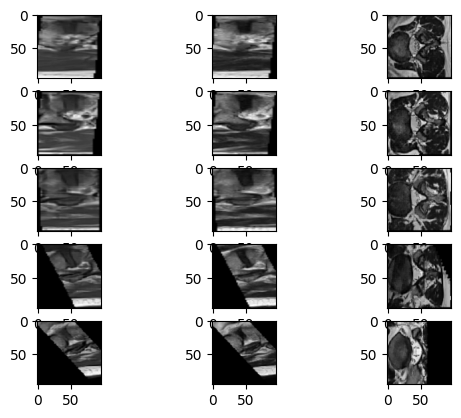

In [5]:
f, axs = plt.subplots(5, 3)

index = 0

for i in range(index * 5, (index + 1) * 5):
    row = bounding_boxes.iloc[i]
    level = row['level'].replace("/", "").lower()
    min_bound = np.array([row['x_min'], row['y_min'], row['z_min']])
    max_bound = np.array([row['x_max'], row['y_max'], row['z_max']])

    row_1 = coords.iloc[i]
    row_2 = coords.iloc[i + 1]

    #level = (row_1['level'].str + "_" + row_2["level"].str).lower()
    pt1 = np.array([row_1['x'], row_1['y'], row_1['z']])
    pt2 = np.array([row_2['x'], row_2['y'], row_2['z']])
    
    grid = read_vertebral_level_as_voxel_grid_nonaligned(
        f"../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row_1['study_id']}",
        vertebral_level=level,
        center_point_pair=(pt1,pt2),
        min_bound=min_bound,
        max_bound=max_bound,
        series_type_dict=series_descs,
        voxel_size=(96, 96, 96),
        caching=False
    )
    
    # grid = tf(grid.astype(np.float32))
    
    axs[i % 5, 0].imshow(grid[0, 28], cmap="gray")
    axs[i % 5, 1].imshow(grid[2, 28], cmap="gray")
    axs[i % 5, 2].imshow(grid[1, :, :, 50], cmap="gray")
    
plt.show()